In [74]:
import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import healpy as hp
from pylab import cm as cmaps
from tqdm import *
from astropy import units as u
from pylab import rcParams
import matplotlib.pylab as pylab
from cycler import cycler
import palettable
from scipy.ndimage.filters import gaussian_filter

from theory.units import *
from simulation.astrometry_sim import QuasarSim
from simulation.estimator_wholesky import get_vector_alm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

In [76]:
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/Draft/plots/"
data_dir = "/Users/smsharma/QuasarSims/"

In [81]:
max_sep = 5
nside = 128
lmax = 3*nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True, 
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=True, 
                do_alpha=True,
                sh_profile='Gaussian')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3*kpc, R_max=260*kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.analysis_pipeline()

Simulating 1172 subhalos between 7.0 and 10.0


In [78]:
# np.save("../../data/mu_qsrs", sim.mu_qsrs)
# np.save("../../data/alpha_qsrs", sim.alpha_qsrs)

In [82]:
maxx = 8e-4
maxx_a = 2e-10

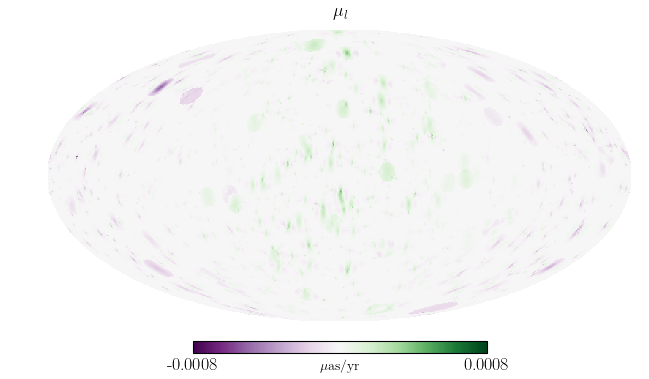

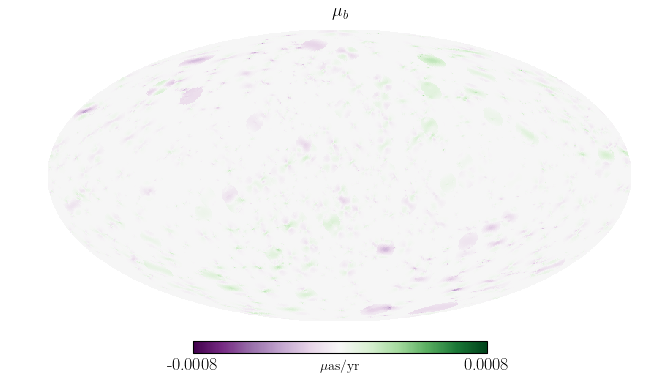

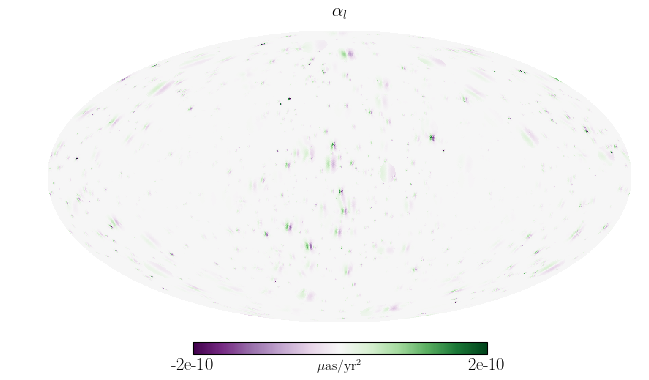

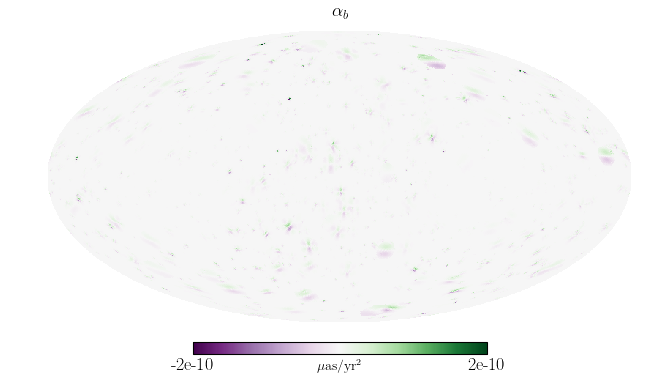

In [83]:
cmap = cmaps.PRGn
# cmap = palettable.cmocean.diverging.Curl_14_r.get_mpl_colormap()
cmap.set_under('w')

hp.mollview(1e6*sim.mu_qsrs[:,0],max=maxx, min=-maxx, title="$\mu_l$", unit='$\mu$as/yr', cmap=cmap)
# plt.savefig(plots_dir + "/mu_l.pdf" )
hp.mollview(1e6*sim.mu_qsrs[:,1],max=maxx, min=-maxx, title="$\mu_b$", unit='$\mu$as/yr', cmap=cmap)
# plt.savefig(plots_dir + "/mu_b.pdf" )
hp.mollview(1e6*sim.alpha_qsrs[:,0],max=maxx_a, min=-maxx_a, title="$\\alpha_l$", unit='$\mu$as/yr$^2$', cmap=cmap)
# plt.savefig(plots_dir + "/alpha_l.pdf" )
hp.mollview(1e6*sim.alpha_qsrs[:,1],max=maxx_a, min=-maxx_a, title="$\\alpha_b$", unit='$\mu$as/yr$^2$', cmap=cmap)
# plt.savefig(plots_dir + "/alpha_b.pdf" )

In [84]:
lmin_plot = 10
lmax_plot = 300

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '$\\log_{10}(|\\Psi_{lm}|^2\\,[\\mu$as$^2$\\,yr$^{-2}])$')

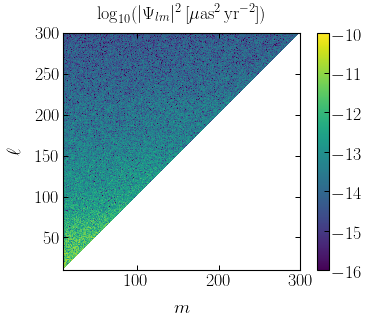

In [85]:
plt.imshow((np.log10((np.abs(sim.fB*1e6)**2)[lmin_plot:lmax_plot,lmin_plot:lmax_plot])), 
           origin='lower', vmin=-16, vmax=-10,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot]
          )
cbar = plt.colorbar()

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title("$\log_{10}(|\Psi_{lm}|^2\,[\mu$as$^2$\,yr$^{-2}])$")

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '$\\log_{10}(|\\Psi_{lm}|^2\\,[\\mu$as$^2$\\,yr$^{-2}])$')

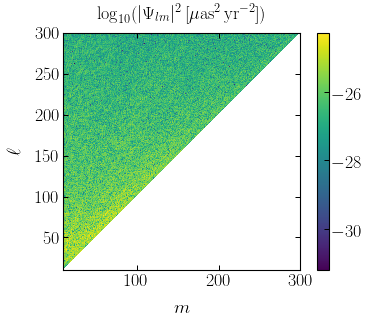

In [89]:
plt.imshow((np.log10((np.abs(sim.fB_alpha*1e6)**2)[lmin_plot:lmax_plot,lmin_plot:lmax_plot])), 
           origin='lower',
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot]
          )
cbar = plt.colorbar()

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title("$\log_{10}(|\Psi_{lm}|^2\,[\mu$as$^2$\,yr$^{-2}])$")

## Analyze cluster runs

In [11]:
nsim = 300
rcParams['figure.figsize'] = 6, 5

nside = 128
lmax = 3*nside - 1


In [12]:
# nside = 128
# lmax = 3*nside - 1

# nch = 2

# ch_ary = np.zeros((nsim, nch, lmax))

# for i in tqdm_notebook(range(nsim)):
#     fB = np.load(data_dir + "/lcdm_nside128_sep20_mc" + str(i) + ".npz")['fB']
#     ch_ary[i, :, :] = np.transpose([[np.mean(split_ary) for split_ary in np.array_split((np.abs(fB)**2)[l][:l], nch)] for l in range(lmax)])

In [13]:
# ch_1 = 1e12*2*np.percentile(ch_ary[:,0,1:], [16,50,84], axis=0)
# ch_2 = 1e12*2*np.percentile(ch_ary[:,1,1:], [16,50,84], axis=0)

# ell = np.arange(1, len(ch_1[0]) + 2)

In [14]:
# rcParams['figure.figsize'] = 6, 5

# alpha_plot = 0.05
# lw_plot = 1.5

# plt.plot(ell[1:], ch_1[1], label="Low-$m$ modes", color='orange', lw = lw_plot)
# plt.fill_between(ell[1:], ch_1[0], ch_1[2], alpha=alpha_plot, color='orange')

# plt.plot(ell[1:], ch_2[1], label="High-$m$ modes", color='dodgerblue', lw = lw_plot)
# plt.fill_between(ell[1:], ch_2[0], ch_2[2], alpha=alpha_plot, color='dodgerblue')

# plt.xlim(10, 200)
# plt.ylim(1e-13,1e-9)
# plt.xscale("log")
# plt.yscale("log")

# plt.legend(frameon=False)

# plt.title('\\textbf{Azimuthal mode asymmetry, CDM}', fontsize=17, y=1.02)

# plt.xlabel("$\ell$")
# plt.ylabel("$\langle C_\ell^{\\mu (1)}\\rangle$ [$\mu$as$^2$\,yr$^{-2}$]")

# plt.tight_layout()
# # plt.savefig(plots_dir + "m_asymm_2.pdf")

In [42]:
fB_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(range(nsim)):
    fB = np.load(data_dir + "/lcdm_nside128_noasymm_sep20_mc" + str(i) + ".npz")['fC']
    fB_ary += np.abs(fB*1e6)**2
fB_ary /= nsim

In [43]:
lmin_plot = 10
lmax_plot = 200

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


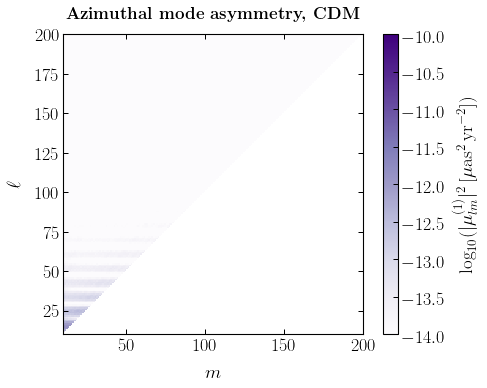

In [44]:
rcParams['figure.figsize'] = 7, 5.5

plt.imshow((np.log10((fB_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot])), 
           origin='lower', vmin=-14, vmax=-10,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap=plt.get_cmap('Purples')
          )
cbar = plt.colorbar(label="$\log_{10}(|\mu_{lm}^{(1)}|^2\,[\mu$as$^2$\,yr$^{-2}])$")

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title('\\textbf{Azimuthal mode asymmetry, CDM}', fontsize=17, y=1.02)

plt.tight_layout()
# plt.savefig(plots_dir + "m_asymm_1.pdf")

In [18]:
fB_ary_compressed = (fB_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]

In [19]:
av_ary = np.zeros_like(fB_ary_compressed)
for l in range(len(av_ary)):
    thing = np.where(fB_ary_compressed[l, :]!=0,fB_ary_compressed[l, :],np.nan)
    av_ary[l, :l] = ((thing - np.nanmean(thing)) / np.nanmean(thing))[:l]
# plt.plot((thing - np.nanmean(thing)) / thing)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


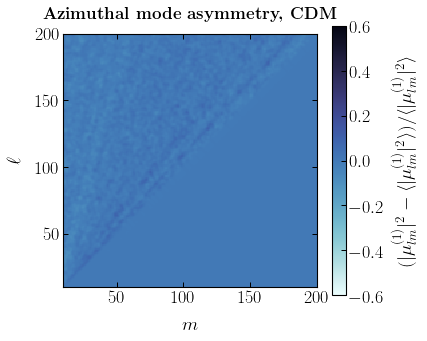

In [20]:
plt.imshow(gaussian_filter(av_ary, 1.), 
           origin='lower', vmin=-0.6, vmax=0.6,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap=palettable.cmocean.sequential.Ice_20_r.get_mpl_colormap()
          )

cbar = plt.colorbar(label=r"$(|\mu_{lm}^{(1)}|^2 - \langle|\mu_{lm}^{(1)}|^2\rangle) / \langle|\mu_{lm}^{(1)}|^2\rangle$")

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title('\\textbf{Azimuthal mode asymmetry, CDM}', fontsize=17, y=1.02)

plt.tight_layout()
# plt.savefig(plots_dir + "m_asymm_1.pdf")

In [21]:
nsim = 300
lmin_plot = 10
lmax_plot = 200

In [87]:
fB_alpha_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(range(nsim)):
#     fB_alpha = np.load(data_dir + "/lcdm_nside128_sep20_mc" + str(i) + ".npz")['fB_alpha']
    fB_alpha = np.load(data_dir + "/lcdm_nside128_noasymm_sep20_mc" + str(i) + ".npz")['fB_alpha']
    fB_alpha_ary += np.abs(fB_alpha*1e6)**2
fB_alpha_ary /= nsim

In [88]:
fB_alpha_ary_compressed = (fB_alpha_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]

In [89]:
av_alpha_ary = np.zeros_like(fB_alpha_ary_compressed)
for l in range(len(av_alpha_ary)):
    thing = np.where(fB_alpha_ary_compressed[l, :]!=0,fB_alpha_ary_compressed[l, :],np.nan)
    av_alpha_ary[l, :l] = ((thing - np.nanmean(thing)) / np.nanmean(thing))[:l]
# plt.plot((thing - np.nanmean(thing)) / thing)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [90]:
np.mean(fB_alpha_ary)

6.113710839635698e-26

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


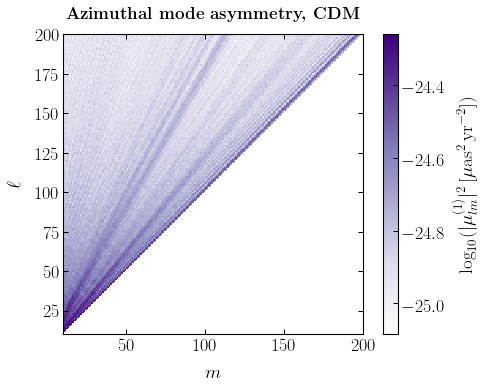

In [91]:
plt.imshow((np.log10((fB_alpha_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot])), 
           origin='lower',
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap=plt.get_cmap('Purples')
          )

cbar = plt.colorbar(label="$\log_{10}(|\mu_{lm}^{(1)}|^2\,[\mu$as$^2$\,yr$^{-2}])$")

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title('\\textbf{Azimuthal mode asymmetry, CDM}', fontsize=17, y=1.02)

plt.tight_layout()


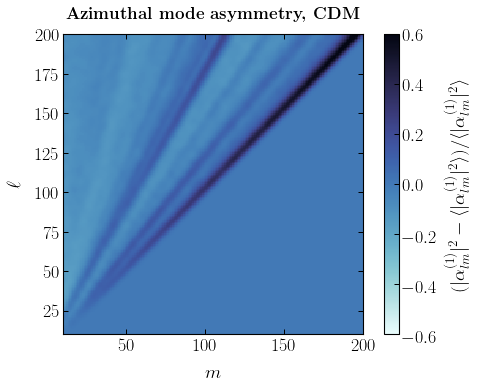

In [92]:
plt.imshow(gaussian_filter(av_alpha_ary, 2), 
           origin='lower', vmin=-0.6, vmax=0.6,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap=palettable.cmocean.sequential.Ice_20_r.get_mpl_colormap(),
          )

cbar = plt.colorbar(label=r"$(|\alpha_{lm}^{(1)}|^2 - \langle|\alpha_{lm}^{(1)}|^2\rangle) / \langle|\alpha_{lm}^{(1)}|^2\rangle$")

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title('\\textbf{Azimuthal mode asymmetry, CDM}', fontsize=17, y=1.02)

plt.tight_layout()
# plt.savefig(plots_dir + "m_asymm_alpha_1.pdf")

In [2]:
# fB_ary_compressed_means = np.nanmean(np.where(fB_ary_compressed!=0,fB_ary_compressed,np.nan),axis=1)

In [1]:
# fB_ary_compressed_means = np.nanmean(np.where(fB_ary_compressed!=0,fB_ary_compressed,np.nan),axis=0)

# plt.imshow(fB_ary_compressed/fB_ary_compressed_means, 
#            origin='lower', vmin=0.0, vmax=1.6,
#            extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
#            cmap=plt.get_cmap('viridis')
#           )

# cbar = plt.colorbar(label="$\log_{10}(|\mu_{lm}^{(1)}|^2\,[\mu$as$^2$\,yr$^{-2}])$")

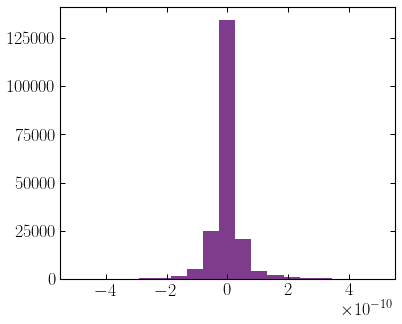

In [352]:
plt.hist(np.load(data_dir + "/lcdm_nside128_altroll_sep20_mc" + str(0) + ".npz")['mu_qsrs'][1], bins=np.linspace(-5e-10, 5e-10, 20));

In [355]:
np.mean(np.load(data_dir + "/lcdm_nside128_altroll_sep20_mc" + str(0) + ".npz")['mu_qsrs'][1])

1.851835144724408e-12

In [20]:
b_vec = np.array([2,1])
b_dot_v = 3
b = 2
v_vec = np.array([1,2])

dMdb = 12 # 3
d2Mdb2 = 12 # 6
M =  8 # 1

factor = (6 * b_vec * b_dot_v ** 2 * M - 2 * b *
          ((2 * v_vec * b_dot_v + b_vec * np.dot(v_vec,
                                                 (v_vec * b - b_vec * b_dot_v) / b ** 2)) * M +
           2 * b_vec * b_dot_v ** 2 * dMdb) + b ** 2 *
          ((2 * v_vec * b_dot_v + b_vec * np.dot(v_vec, (v_vec * b - b_vec * b_dot_v) / b ** 2))
           * dMdb + b_vec * b_dot_v ** 2 * d2Mdb2)) / b ** 4
print(factor)

[ 5.  11.5]


In [25]:
sim.MdMdb_NFW(1,1,1)

(-0.002193945697744577, 7.837993675449573e-12, 7.300783743980227e-12)

In [28]:
sim.MdMdb_NFW(1,1,1)

(-0.002193945697744577, 7.837993675449573e-12, 7.301363501153436e-12)

In [30]:
from scipy.misc import derivative

In [44]:
x = 0.999
print(sim.dFdx(x))
print(derivative(sim.F, x, 1e-2))

-0.6676010296264975
-0.6676354230660042


In [73]:
x = 0.7
print(sim.d2Fdx2(x))
print(derivative(lambda x: derivative(sim.F, x, 1e-3), x, 1e-3))

2.0141607130871453
2.014169422914769
